<a href="https://colab.research.google.com/github/RafaelSdeS/real_estate_analysis/blob/main/real_estate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping - Gather real estate data

In [25]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import numpy as np

In [26]:
from google.colab import userdata
base_url = userdata.get('base_url')
print(base_url)

https://www.bancodeimoveis.net/imoveis/a-venda/rs/santa-maria?


In [27]:
def gather_real_estate_data(base_url=base_url, max_pages=1):
    page = 1
    all_properties = []

    while page <= max_pages:
        url = f"{base_url}&pagina={page}"
        try:
            #Get all the properties from the main page
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'html.parser')
            properties = soup.find_all('div', class_="container-card imovel-item simple-imovel-item imoveis-list-card lighter-bg")

            for property in properties:
                try:
                    #Get the link for every property
                    property_link = property.find("a", class_="imovel-image-container").get("href")
                    property_type = property.find("div", class_="primary-bg ballon").text

                    #Use the link to access each property
                    property_response = requests.get(property_link)
                    property_soup = BeautifulSoup(property_response.text, "html.parser")

                    # Address
                    address_info = property_soup.find("div", class_="imovel-info-box-content notranslate")
                    if address_info:
                        street = address_info.find_all("p")[0].text.strip() if (address_info.find_all("p")[0].text.strip()) else None
                        neighborhood = address_info.find_all("p")[1].text.strip() if len(address_info.find_all("p")) > 1 else "Unavailable"
                        city = address_info.find_all("p")[2].text.strip() if len(address_info.find_all("p")) > 2 else "Unavailable"
                    else:
                      street = None
                      neighborhood = None
                      city = None

                    # Areas -> The areas will be objects, not floats, as there will be a "Unavailable" string
                    built_area = property_soup.find("i", class_="imovel-icon far fa-house-window").find_next_sibling("strong").text if property_soup.find("i", class_="imovel-icon far fa-house-window") else None
                    private_area = property_soup.find("i", class_="imovel-icon far fa-house-user").find_next_sibling("strong").text if property_soup.find("i", class_="imovel-icon far fa-house-user") else None

                    # Convert strings to floats -> The areas will be objects, not floats, as there will be a "Unavailable" string
                    built_area_float = float(built_area.replace('.', '').replace(',', '.').replace('m²', '').strip()) if built_area != None else None
                    private_area_float = float(private_area.replace('.', '').replace(',', '.').replace('m²', '').strip()) if private_area != None else None

                    #Bedrooms, bathrooms, suites and parking spaces
                    bedrooms_strong = property_soup.find("strong", string=lambda t: t and t.isdigit())
                    if bedrooms_strong:
                        bedrooms = bedrooms_strong.text.strip() if bedrooms_strong.text else 0
                        if bedrooms_strong.find_next_sibling("small"):
                          suites = bedrooms_strong.find_next_sibling("small").text.strip()[0]
                        else:
                          suites = 0
                        bathrooms = property_soup.find("i", class_="imovel-icon fas fa-bath").find_next_sibling("strong").text if property_soup.find("i", class_="imovel-icon fas fa-bath") else 0
                        parking_spaces = property_soup.find("i", class_="imovel-icon fa fa-car").find_next_sibling("strong").text if property_soup.find("i", class_="imovel-icon fa fa-car") else 0
                    else:
                        bedrooms = 0
                        suites = 0
                        bathrooms = 0
                        parking_spaces = 0

                    # Convert other numeric fields to float if they are not "Unavailable" or "Not Available"
                    bedrooms = int(bedrooms) #if bedrooms != "Unavailable" else None
                    suites = int(suites) #if suites != "No Suites" else None
                    bathrooms = int(bathrooms) #if bathrooms != "Unavailable" else None
                    parking_spaces = int(parking_spaces) #if parking_spaces != "Unavailable" else 0

                    #Monetary information
                    monetary_info = property_soup.find_all("div", class_="imovel-info-box-content")[3]

                    price = monetary_info.find_all('strong', class_='text text-very-large')[0].text if monetary_info.find_all('strong', class_='text text-very-large')[0] else None
                    iptu = monetary_info.find('small', class_='text', string=lambda t: "IPTU" in t).find_next_sibling("strong").text if monetary_info.find('small', class_='text', string=lambda t: "IPTU" in t) else None
                    condominium = monetary_info.find('small', class_='text', string=lambda t: "Condomínio" in t).find_next_sibling("strong").text if monetary_info.find('small', class_='text', string=lambda t: "Condomínio" in t) else None

                    # Convert strings to floats
                    try:
                      price_float = float(price.replace('R$', '').replace('.', '').replace(',', '').strip()) if price != None else None
                    except ValueError:
                      price_float = None
                    iptu_float = float(iptu.replace('R$', '').strip()) if iptu != None else None
                    condominium_float = float(condominium.replace('R$', '').strip()) if condominium != None else None

                    #Grill
                    group = property_soup.find_all("div", class_="list-group-item")[2]
                    result = group.find(lambda tag: tag.name == 'li' and tag.get_text().strip() == "Churrasqueira") if group else False

                    if result:
                      grill = True
                    else:
                      grill = False


                    property_data = {
                        "Link": property_link,
                        "Type": property_type,
                        "City": city,
                        "Neighborhood": neighborhood,
                        "Street": street,
                        "Price": price_float,
                        "Private Area": private_area_float,
                        "Built Area": built_area_float,
                        "Bedrooms": bedrooms,
                        "Suites": suites,
                        "Bathrooms": bathrooms,
                        "Parking Spaces": parking_spaces,
                        "IPTU": iptu_float,
                        "Condominium": condominium_float,
                        "Grill": grill,
                    }

                    all_properties.append(property_data)

                except (AttributeError, IndexError) as e:
                    print(f"Skipping property due to error: {e}")

        except requests.exceptions.RequestException as e:
            print(f"Failed to retrieve page {page}: {e}")

        page += 1

    df = pd.DataFrame(all_properties)
    return df


In [28]:
print(gather_real_estate_data())

Skipping property due to error: 'NoneType' object has no attribute 'text'
                                                 Link                Type  \
0   https://www.bancodeimoveis.net/imovel/casa-de-...  Casa de Condomínio   
1   https://www.bancodeimoveis.net/imovel/cobertur...           Cobertura   
2   https://www.bancodeimoveis.net/imovel/apartame...         Apartamento   
3   https://www.bancodeimoveis.net/imovel/area-rur...          Área Rural   
4   https://www.bancodeimoveis.net/imovel/area-rur...          Área Rural   
5   https://www.bancodeimoveis.net/imovel/chacara-...             Chácara   
6   https://www.bancodeimoveis.net/imovel/apartame...         Apartamento   
7   https://www.bancodeimoveis.net/imovel/apartame...         Apartamento   
8   https://www.bancodeimoveis.net/imovel/apartame...         Apartamento   
9   https://www.bancodeimoveis.net/imovel/casa-2-d...                Casa   
10  https://www.bancodeimoveis.net/imovel/casa-2-d...                Casa   

 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

Mounted at /content/drive


In [ ]:
directory_path = '/content/drive/MyDrive/RealEstateData'

def save_to_csv(df):
  if not os.path.exists(directory_path):
    os.makedirs(directory_path)
  file_path = os.path.join(directory_path, 'real_estate_data.csv')
  df.to_csv(file_path, sep=',', index=False, header=True)
  df.to_csv("real_estate_data.csv", sep=',', index=False, header=True)

In [ ]:
#save_to_csv(gather_real_estate_data(base_url, 94)) #Run this to create CSV file

# Data Analysis

## Imports and remove outliers

In [ ]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
directory_path = '/content/drive/MyDrive/RealEstateData'

def save_to_csv(df):
  if not os.path.exists(directory_path):
    os.makedirs(directory_path)
  file_path = os.path.join(directory_path, 'real_estate_data.csv')
  df.to_csv(file_path, sep=',', index=False, header=True)
  df.to_csv("real_estate_data.csv", sep=',', index=False, header=True)

In [ ]:
real_estate_data = pd.read_csv(directory_path + '/real_estate_data.csv')

In [ ]:
upper_bound_private_area = real_estate_data['Private Area'].quantile(0.99)

real_estate_data = real_estate_data[real_estate_data['Private Area'] <= upper_bound_private_area]

In [ ]:
upper_bound_price = real_estate_data['Price'].quantile(0.99)

real_estate_data = real_estate_data[real_estate_data['Price'] <= upper_bound_price]

In [ ]:
real_estate_data.head()

Link         Type  \
0  https://www.bancodeimoveis.net/imovel/apartame...  Apartamento   
1  https://www.bancodeimoveis.net/imovel/apartame...  Apartamento   
2  https://www.bancodeimoveis.net/imovel/apartame...  Apartamento   
3  https://www.bancodeimoveis.net/imovel/cobertur...    Cobertura   
4  https://www.bancodeimoveis.net/imovel/apartame...  Apartamento   

                City              Neighborhood                         Street  \
0  Santa Maria -  RS                    Centro             Rua do Acampamento   
1  Santa Maria -  RS                    Camobi  Avenida Prefeito Evandro Behr   
2  Santa Maria -  RS                    Centro                     Rua Tuiuti   
3  Santa Maria -  RS  Nossa Senhora de Lourdes             Rua Osvaldo Aranha   
4  Santa Maria -  RS                    Camobi  Avenida Prefeito Evandro Behr   

      Price  Private Area  Built Area  Bedrooms  Suites  Bathrooms  \
0  320000.0        120.00         NaN         3       0          2   
1  430000.0         69.61       91.22         2       0          2   
2  320000.0        101.00      122.00         3       0          2   
3  300000.0        119.00      145.00         2       0          2   
4  790253.0        126.86      175.18         3       1          2   

   Parking Spaces  IPTU  Condominium  Grill  
0               0  60.0        370.0  False  
1               1   NaN        300.0  False  
2               1   NaN          NaN   True  
3               2   NaN        300.0  False  
4               1   NaN          NaN   True

## Private Area Graphs

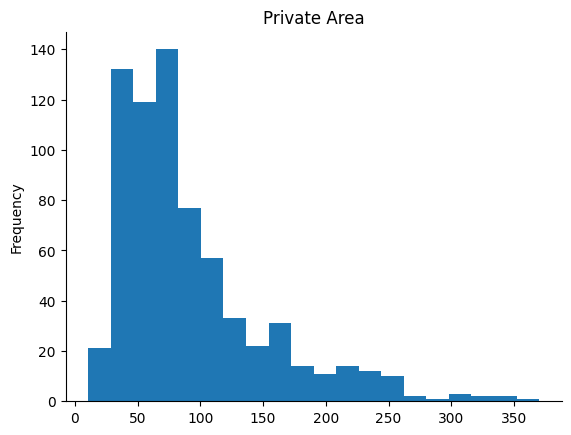

In [ ]:
real_estate_data['Private Area'].plot(kind='hist', bins=20, title='Private Area')
plt.gca().spines[['top', 'right',]].set_visible(False)

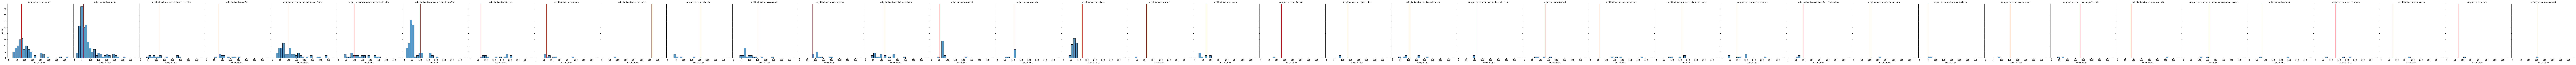

In [ ]:
average_values = real_estate_data.groupby("Neighborhood")["Private Area"].mean().reset_index()

sns.displot(data=real_estate_data, x="Private Area", col="Neighborhood")

for i, row in enumerate(average_values.itertuples()):
    ax = plt.gcf().axes[i]
    # Assuming the DataFrame columns are ['Neighborhood', 'Private Area']
    _, neighborhood, private_area = row
    ax.axvline(x=private_area, color='red')

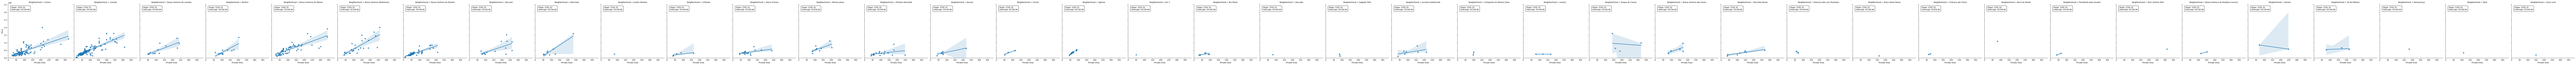

In [ ]:
# Fit the model
model = LinearRegression().fit(real_estate_data[['Private Area']], real_estate_data['Price'])

# Extract intercept and slope correctly
intercept = model.intercept_
slope = model.coef_[0]

# Plotting
sns.lmplot(data=real_estate_data, x="Private Area", y="Price", col="Neighborhood")
plt.xlim(left=0)
plt.ylim(bottom=0)

for ax in plt.gcf().axes:
    # Annotate the slope and intercept
    ax.annotate(f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                ha='left', va='top', fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.show()

In [ ]:
df_apartment = real_estate_data[real_estate_data["Type"] == "Apartamento"]

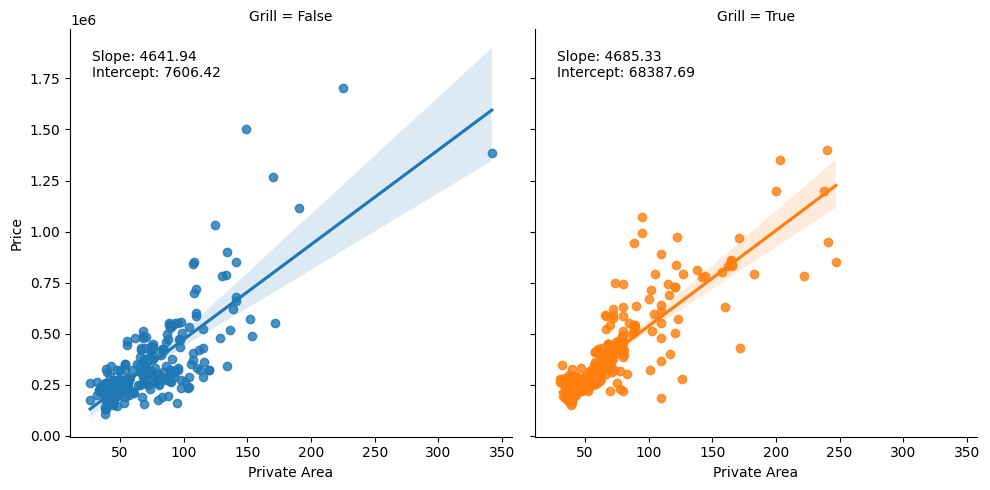

In [ ]:
from sklearn.linear_model import LinearRegression

grill_types = df_apartment['Grill'].unique()
g = sns.lmplot(data=df_apartment, x="Private Area", y="Price", hue="Grill", col="Grill")

for ax, grill_type in zip(g.axes.flat, grill_types):
    df_current_grill = df_apartment[df_apartment['Grill'] == grill_type]

    # Fit linear regression model for current grill type
    model = LinearRegression().fit(df_current_grill[["Private Area"]], df_current_grill[["Price"]])
    intercept = model.intercept_[0]
    slope = model.coef_[0][0]

    # Annotate the slope and intercept on the plot
    ax.annotate(f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                ha='left', va='top', fontsize=10, color='black')

plt.show()

## Price/Square Meter

In [ ]:
real_estate_data["Price Per Square Meter"] = real_estate_data["Price"]/real_estate_data["Private Area"]
real_estate_data["Price Per Square Meter"] = real_estate_data["Price Per Square Meter"].round(2)

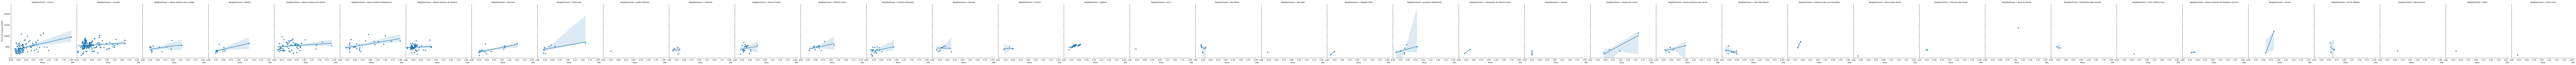

In [ ]:
sns.lmplot(x="Price", y="Price Per Square Meter", data=real_estate_data, col="Neighborhood")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

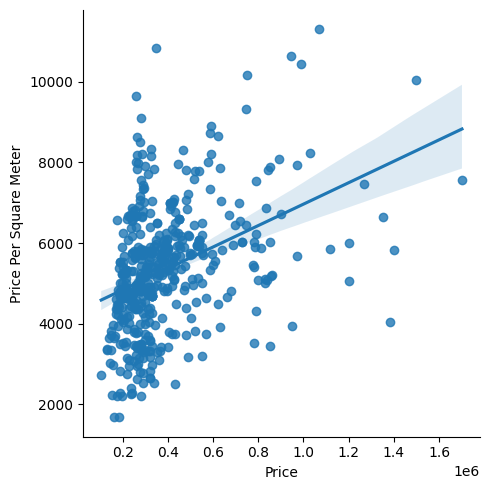

In [ ]:
sns.lmplot(x="Price", y="Price Per Square Meter", data=df_apartment)

#Machine Learning

##Preprocessing the data

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

real_estate_data["Neighborhood"] = le.fit_transform(real_estate_data["Neighborhood"])
real_estate_data["Type"] = le.fit_transform(real_estate_data["Type"])

In [ ]:
print(real_estate_data.iloc[3])

Link              https://www.bancodeimoveis.net/imovel/cobertur...
Type                                                              6
City                                              Santa Maria -  RS
Neighborhood                                                     22
Street                                           Rua Osvaldo Aranha
Price                                                      300000.0
Private Area                                                  119.0
Built Area                                                    145.0
Bedrooms                                                          2
Suites                                                            0
Bathrooms                                                         2
Parking Spaces                                                    2
IPTU                                                            NaN
Condominium                                                   300.0
Grill                                           

##The actual stuff

In [ ]:
features = real_estate_data[['Type', 'Neighborhood', 'Bedrooms', 'Bathrooms', 'Suites', 'Parking Spaces', 'Private Area', 'Grill']]
target = real_estate_data['Price']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 45319396279.77332


In [ ]:
scenario = {'Type': 6, 'Neighborhood': 22,'Bedrooms': 2, 'Bathrooms': 2,  'Suites':0, 'Parking Spaces': 2, "Private Area": 80, 'Grill': 119,}
scenario_df = pd.DataFrame(scenario, index=[0])
predicted_price = model.predict(scenario_df)
print(f'The predicted price for the scenario is: R${predicted_price[0]:,.2f}')


The predicted price for the scenario is: R$262,750.00


In [ ]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# Export a single tree
dot_data = export_graphviz(model.estimators_[0], out_file=None, feature_names=features.columns, class_names=['price'], filled=True, rounded=True, special_characters=True)

# Render the tree
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'Price' is your target variable
features = real_estate_data[['Type', 'Neighborhood', 'Bedrooms', 'Bathrooms', 'Suites', 'Parking Spaces', 'Private Area', 'Grill']]
target = real_estate_data['Price']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=42, max_depth=4)
tree_model.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = tree_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}')

MAE: 136238.39207115542, MSE: 63236731262.50903, R^2: 0.23530165666279634


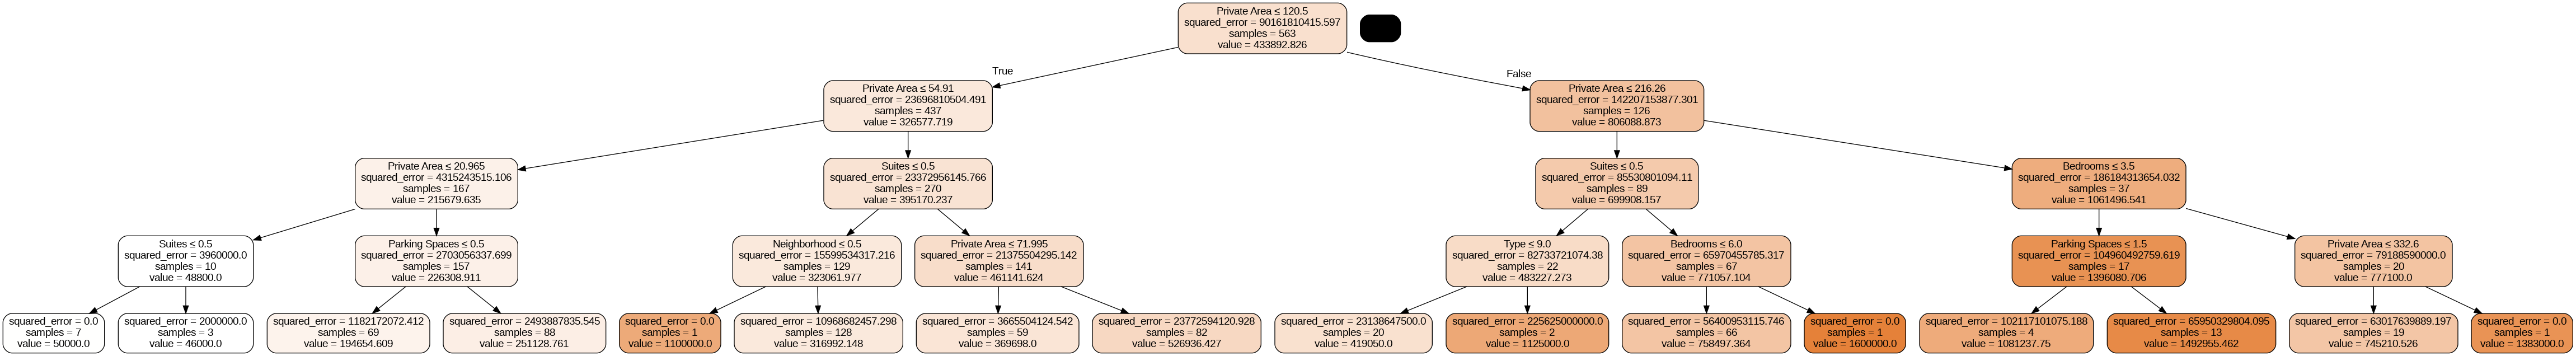

In [ ]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

dot_data = export_graphviz(tree_model, out_file=None,
                           feature_names=features.columns,
                           class_names=["Price"],
                           filled=True, rounded=True,
                           special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
scenario = {'Type': 6, 'Neighborhood': 22,'Bedrooms': 2, 'Bathrooms': 2,  'Suites':0, 'Parking Spaces': 2, "Private Area": 80, 'Grill': 119,}
scenario_df = pd.DataFrame(scenario, index=[0])
predicted_price = tree_model.predict(scenario_df)

print(f'The predicted price for the scenario is: R${predicted_price[0]:,.2f}')

The predicted price for the scenario is: R$316,992.15
